## Business Understanding
What are the busiest times of the year to visit Boston? <br>
How is the available listings changing across the Boston ?

## Data Understanding
I decide to use two values to attack the first question: the mean price and number of the available listings. <br>
For the second I need to load the position of the listings

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,normalize
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
df_calendar = pd.read_csv('boston/calendar.csv')

In [3]:
df_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


### Data Prepare

In [4]:
df_calendar.dtypes # we need change the price to float

listing_id     int64
date          object
available     object
price         object
dtype: object

In [5]:
df_calendar['available'].value_counts(dropna=False)

f    665853
t    643037
Name: available, dtype: int64

In [6]:
#check consistance
#price and available are highly correlated
df_calendar['price'][df_calendar['available']=='f'].isnull().mean() #should be all NaN

1.0

In [7]:
df_calendar['price'][df_calendar['available']=='t'].isnull().mean() #should all none NaN

0.0

Price is object, need to change to float

In [8]:
#make all price to str
df_calendar['price'] = df_calendar['price'].astype('str')

In [9]:
df_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,nan
1,12147973,2017-09-04,f,nan
2,12147973,2017-09-03,f,nan
3,12147973,2017-09-02,f,nan
4,12147973,2017-09-01,f,nan


In [10]:
def dollar_to_float(price):
    #input price is string
    #output: float number
    #for 'nan' will use np.nan
    #for ordinary price, will drop '$'
    #and ','
    if price=='nan':
        return np.nan
    res = ""
    for s in price:
        if s !='$' and s !=',':
            res += s
    return float(res)

In [11]:
#change the price to float 
df_calendar['price'] = df_calendar['price'].apply(dollar_to_float)

In [12]:
df_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [13]:
#check the NaN 
df_calendar[['listing_id','date','available']].isnull().mean()

listing_id    0.0
date          0.0
available     0.0
dtype: float64

In [14]:
#map the available to True or False
df_calendar['available'] = df_calendar['available'].map({'t':True,'f':False})

In [15]:
df_calendar.dtypes

listing_id      int64
date           object
available        bool
price         float64
dtype: object

In [16]:
#change str date to datetime
df_calendar['date'] = pd.to_datetime(df_calendar['date'],format='%Y-%m-%d')

In [17]:
df_calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [18]:
#check data after changes
df_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,False,NaN
1,12147973,2017-09-04,False,NaN
2,12147973,2017-09-03,False,NaN
3,12147973,2017-09-02,False,NaN
4,12147973,2017-09-01,False,NaN


In [19]:
df_calendar.set_index('date',inplace=True) #set index to be the date

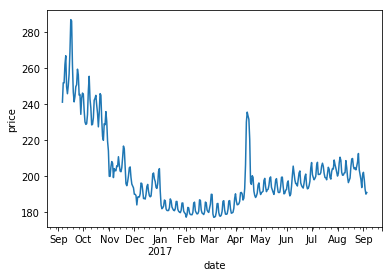

In [21]:
#check mean price by day
df_calendar['price'].resample('D').mean().plot();
plt.ylabel('price');

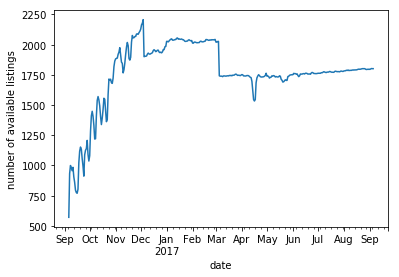

In [23]:
#let's check the available listing per day
# number of available listing and mean price seems 
#having strong correlation
df_calendar.resample('D')['available'].sum().plot();
plt.ylabel('number of available listings');

In [24]:
#they seems to be anticorrolated , let's plot them together
#but normlize first
price_mean_per_day=df_calendar['price'].resample('D').mean()
avai_sum_per_day=df_calendar.resample('D')['available'].sum()

In [25]:
#get mean and std of the mean price and available listings per day
#for normlize
avai_sum_per_day_mean = avai_sum_per_day.mean()
avai_sum_per_day_std=avai_sum_per_day.std()
price_mean_per_day_mean = price_mean_per_day.mean()
price_mean_per_day_std=price_mean_per_day.std()

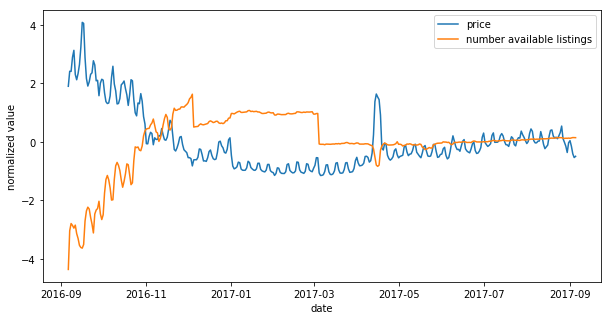

In [26]:
#draw the normalized price per day and available listings per day
#
plt.figure(figsize=(10,5))
plt.plot(price_mean_per_day.index,(price_mean_per_day.values-price_mean_per_day_mean)/price_mean_per_day_std,label='price');
plt.plot(avai_sum_per_day.index,(avai_sum_per_day.values-avai_sum_per_day_mean)/avai_sum_per_day_std,label='number available listings');
plt.legend(loc='upper right');
plt.xlabel('date');
plt.ylabel('normalized value');

the price and number of available listings are strongly correlated: when number of available listings increases,
the price drops, which may be a result of comptition.The number of available listings peaks at December,this may imply a busiest time of visiting boston. For the price,we can see some fluctuation, let's check by week day

### Check the price by week day

In [27]:
#reset the index to get day of week
df_calendar = df_calendar.reset_index()

In [28]:
df_calendar['day_of_week'] = df_calendar['date'].dt.day_name()

In [30]:
#check which day has the higest price
#Friday and Saturday have higher price
df_calendar.groupby('day_of_week')['price'].mean()

day_of_week
Friday       203.121167
Monday       195.809561
Saturday     203.408387
Sunday       198.219764
Thursday     198.073112
Tuesday      195.173842
Wednesday    195.418228
Name: price, dtype: float64

In [35]:
#check the number of the available listings of day in week
#Tuesday has the highest avaiable listings number
df_calendar.groupby('day_of_week')['available'].sum()

day_of_week
Friday       90998.0
Monday       92413.0
Saturday     91068.0
Sunday       92208.0
Thursday     91202.0
Tuesday      93332.0
Wednesday    91816.0
Name: available, dtype: float64

In [31]:
#reset index to create day_of_week columns
price_mean_per_day=price_mean_per_day.reset_index()

In [33]:
price_mean_per_day['day_of_week'] = price_mean_per_day['date'].dt.day_name()


In [34]:
price_mean_per_day.head()

,date,price,day_of_week,day_of_week_n
0,2016-09-06,241.043860,Tuesday,1
1,2016-09-07,251.833691,Wednesday,2
2,2016-09-08,251.748749,Thursday,3
3,2016-09-09,261.859327,Friday,4
4,2016-09-10,266.847280,Saturday,5


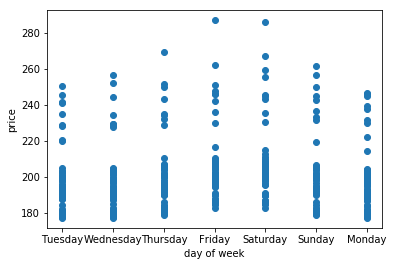

In [37]:
#it looks like Friday and Saturday have the highest price, this may indicate more people arrive at Friday and 
#Saturday
plt.scatter(price_mean_per_day['day_of_week'],price_mean_per_day['price']);
plt.xlabel('day of week');
plt.ylabel('price');

it looks like Friday and Saturday have the highest price, this may indicate more people arrive at Friday and 
Saturday

### Let's check the available listing in different area in different month

In [73]:
#reading list information
df_listings = pd.read_csv('boston/listings.csv')

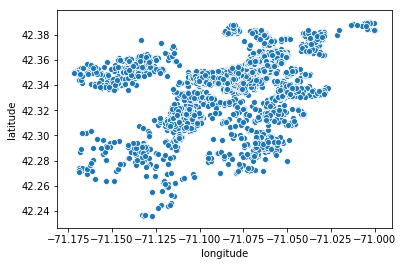

In [74]:
sb.scatterplot(x='longitude',y='latitude',data=df_listings)

In [61]:
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [75]:
#we only interested in position
df_list_pos = df_listings[['id','longitude','latitude']].copy()

In [77]:
#changing the name id to listing_id
df_list_pos=df_list_pos.rename({'id':'listing_id','longitude':'longitude','latitude':'latitude'},axis='columns')

In [78]:
df_list_pos.shape

(3585, 3)

In [79]:
#merge the position information
df_merge = pd.merge(df_calendar,df_list_pos,how='inner',on='listing_id')

In [80]:
df_merge.head()

,date,listing_id,available,price,day_of_week,longitude,latitude
0,2017-09-05,12147973,False,NaN,Tuesday,-71.133068,42.282619
1,2017-09-04,12147973,False,NaN,Monday,-71.133068,42.282619
2,2017-09-03,12147973,False,NaN,Sunday,-71.133068,42.282619
3,2017-09-02,12147973,False,NaN,Saturday,-71.133068,42.282619
4,2017-09-01,12147973,False,NaN,Friday,-71.133068,42.282619


In [81]:
#create a new column of year month
df_merge['year_month']=df_merge.date.map(lambda x: x.strftime('%Y-%m'))

In [82]:
#let's check how many month do we have
df_merge['year_month'].value_counts()

2017-08    111166
2017-07    111166
2016-12    111166
2017-01    111166
2016-10    111166
2017-03    111166
2017-05    111166
2016-11    107580
2017-04    107580
2017-06    107580
2017-02    100408
2016-09     89650
2017-09     17930
Name: year_month, dtype: int64

In [83]:
df_merge.dtypes

date           datetime64[ns]
listing_id              int64
available                bool
price                 float64
day_of_week            object
longitude             float64
latitude              float64
year_month             object
dtype: object

In [84]:
#create interest year month
year_month_list=['2016-09','2016-10','2016-11','2016-12','2017-01','2017-02',
                 '2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09']

In [85]:
len(year_month_list)

13

In [87]:
#check how many days in each year month
year_month_days_list=[]
for m in year_month_list:
    k = df_merge[df_merge['year_month']==m]['date'].value_counts().shape[0]
    year_month_days_list.append(k)
    

In [88]:
#the last month has only about 5 days we will ignore
year_month_days_list

[25, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 5]

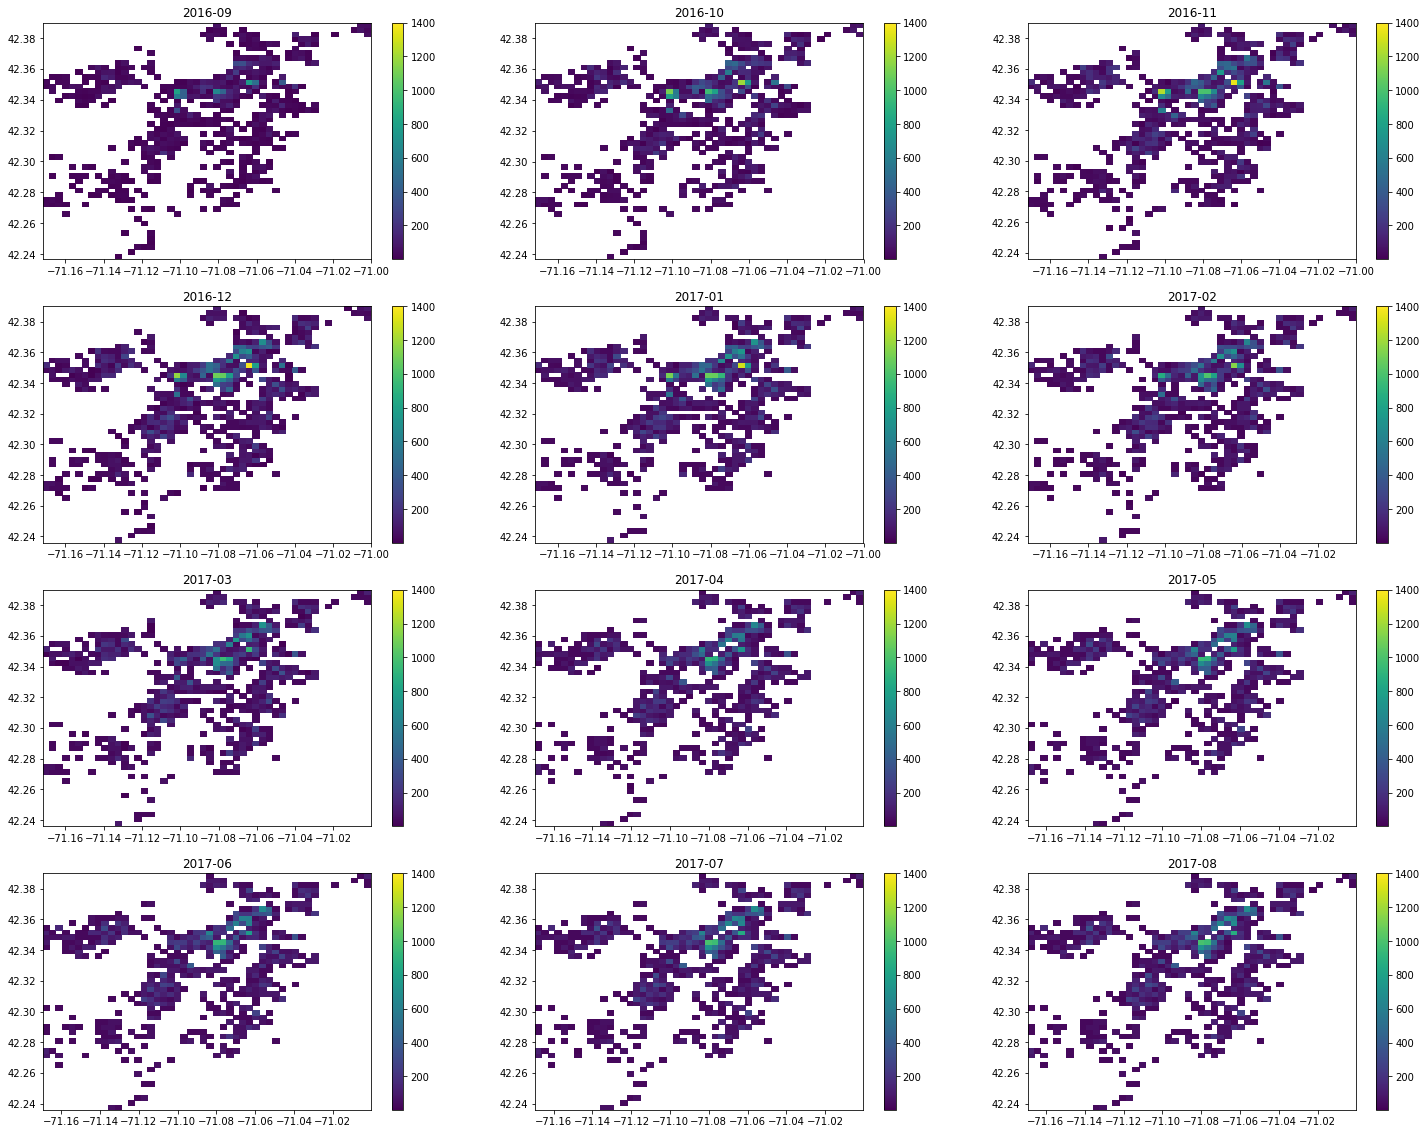

In [99]:
#create a list of plots, show the heatmap of listings position
#each plot stands for one month
#the last month '2017-09' will be excluded
#sine for this month only 5 data collected
#this is a linear scale
f,axarr = plt.subplots(4,3)
f.set_figheight(20)
f.set_figwidth(25)
for i in range(4):
    for j in range(3):
        index = j+3*i
        #print('yearmonth '+year_month_list[index])
        #print('day ',year_month_days_list[index])
        df_merge_month = df_merge[df_merge['year_month']==year_month_list[index]]
        h = axarr[i][j].hist2d(cmin=2,bins=50,x=df_merge_month[df_merge_month['available']==True]['longitude'],
              y=df_merge_month[df_merge_month['available']==True]['latitude'],vmin=2,vmax=1400)
        axarr[i][j].set_title(year_month_list[index]);
        plt.colorbar(h[3], ax=axarr[i][j]);
        

We can see the number of available listings in different area accrossing the year

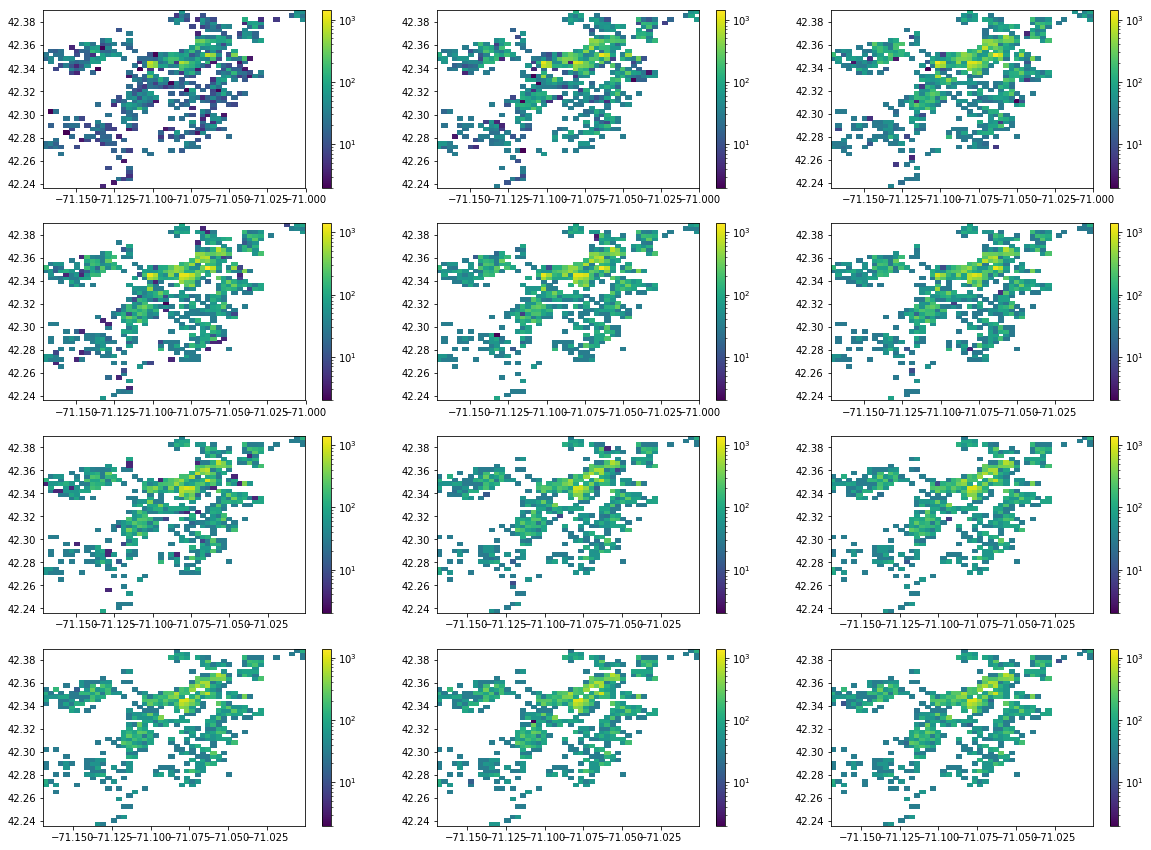

In [101]:
#similar to the previous, this is a log scale 
#we can see more clear the available listings accross
#Boston of different month
f,axarr = plt.subplots(4,3)
f.set_figheight(15)
f.set_figwidth(20)
for i in range(4):
    for j in range(3):
        index = j+3*i
        #print('yearmonth '+year_month_list[index])
        #print('day ',year_month_days_list[index])
        df_merge_month = df_merge[df_merge['year_month']==year_month_list[index]]
        length = df_merge_month[df_merge_month['available']==True].shape[0]
        w = [1./year_month_days_list[index] for s in range(length)]
        h = axarr[i][j].hist2d(cmin=2,bins=50,x=df_merge_month[df_merge_month['available']==True]['longitude'],
              y=df_merge_month[df_merge_month['available']==True]['latitude'],vmin=2,vmax=1400,norm=mpl.colors.LogNorm())
        plt.colorbar(h[3], ax=axarr[i][j]);

## Summary
the price and number of available listings are strongly anti-correlated. The number of available listings peaks at December,this may imply a busiest time of visiting boston. For the price,we can see some fluctuation, this seems like a weekly effect and Friday , Saturday have higher price.Available listings start at center area and then spread to the eadge of the area. Most available is located at center area.